# Project 1: Email Classifier
## Authors: Nigel Nelson, Collin Quinn
## Course: CS4981/031
---
### Imports:


In [1]:
import json
import glob
import os
import sys
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from minio import Minio
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.sparse import csr_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [2]:
os.environ['TS_ACCESS_KEY']='training_service'
os.environ['TS_SECRET_KEY']='minioadmin'
os.environ['TS_ENDPOINT']='127.0.0.1:9000'
os.environ['POSTGRES_USERNAME']='ingestion_service'
os.environ['POSTGRES_PASSWORD']='puppet-soil-SWEETEN'

## Part 1: Loading The Data From Minio:

In [3]:
MINIO_ACESS_KEY='training_service'
MINIO_SECRET_KEY='minioadmin'
MINIO_ENDPOINT='127.0.0.1:9000'
MINIO_BUCKET='emails'

# Exit if environment variable missing
if not MINIO_ACESS_KEY or not MINIO_SECRET_KEY \
   or not MINIO_ENDPOINT or not MINIO_BUCKET:
    print('One of the environment variables (ACESS_KEY/SECRET_KEY/ENDPOINT/BUCKET/LOG_PATH) \
         is missing')
    sys.exit(1)

# Create Minio client
minio_client = Minio(
    endpoint=MINIO_ENDPOINT,
    secure=False, # allow HTTP
    access_key=MINIO_ACESS_KEY,
    secret_key=MINIO_SECRET_KEY
)

In [4]:
files = minio_client.list_objects('emails', recursive=True)
json_files = [object.object_name for object in list(filter(lambda file: '.json' in file.object_name , files))]

email_dicts = []
for file in json_files:
    with minio_client.get_object('emails', file) as response:
        json_str = response.data.decode('utf-8')
        for line in json_str.split('\n')[:-1]: # indexing removes last invalid empty string
            data = json.loads(line)
            email_json = json.loads(data['email_object'])
            email_json['label'] = data['label']
            email_json['received_timestamp'] = data['received_timestamp']
            email_dicts.append(email_json)

In [5]:
email_df = pd.DataFrame.from_dict(email_dicts)
email_df['label'] = email_df['label'].astype('category')
email_df['received_timestamp'] = email_df['received_timestamp'].apply(lambda s: s.replace('T', " "))
email_df['received_timestamp'] = pd.to_datetime(email_df['received_timestamp'])
email_df['label'] = email_df['label'].apply(lambda label: 0 if label == 'ham' else 1)
email_df['label'] = email_df['label'].astype('int')
email_df.head()

,to,body,from,subject,label,received_timestamp
0,"""Pete"" <gnitpick@speedy.uwaterloo.ca>",\n\n\n\n\n\n\nDid you know? You can refinance ...,"""Cecelia"" <sy@speedy.uwaterloo.ca>",eumenides than dada,1,2023-01-26 19:10:19.977000-06:00
1,<mackd@speedy.uwaterloo.ca>,\n\n,"""Viagra.com"" <mackd@speedy.uwaterloo.ca>",Online Doc Nettie,1,2023-01-26 19:10:40.734000-06:00
2,ktwarwic@speedy.uwaterloo.ca,\n\n\n\n\n\nDo you ejaculate before or within ...,"""lufiaguy sidjf"" <lrsohrvftk@co.th>",Realize total and absolute power,1,2023-01-26 19:10:41.291000-06:00
3,"""Hobert"" <theorize@plg.uwaterloo.ca>","\n\n\n\n\n\n\n\n\nup and howl, and she came af...","""Miss"" <bliuehawkiqsfe@tmgnyc.com>",Hope they are all here,1,2023-01-26 19:10:42.761000-06:00
4,"""Adolph"" <the00@plg.uwaterloo.ca>",\n\n\n\n\n\n\nDid you know? You can refinance ...,"""Ann"" <mmw@plg.uwaterloo.ca>",miscible more slack,1,2023-01-26 19:11:04.226000-06:00


In [6]:
email_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype                                 
---  ------              --------------   -----                                 
 0   to                  99411 non-null   object                                
 1   body                100000 non-null  object                                
 2   from                100000 non-null  object                                
 3   subject             99811 non-null   object                                
 4   label               100000 non-null  int32                                 
 5   received_timestamp  100000 non-null  datetime64[ns, pytz.FixedOffset(-360)]
dtypes: datetime64[ns, pytz.FixedOffset(-360)](1), int32(1), object(4)
memory usage: 4.2+ MB


#### Evaluate the class imbalance:

In [61]:
email_df['label'].value_counts()

1    64504
0    35496
Name: label, dtype: int64

## Part 2: Extracting Features

In [8]:
def under_sample_df(df, column):
    """
    Takes the supplied DataFrame, applies under sampling according to the
    column name specified, and returns the under sampled DataFrame.
    """
    desired_count = df[column].value_counts().min()
    mask = df.groupby(column)[column].transform('size') >= desired_count
    df = pd.concat((df[mask].groupby(column).sample(n=desired_count), df[~mask]), ignore_index=True)
    return df

In [9]:
def get_train_test_df(df, train_split, val_split):
    """
    Returns training, validation, and testing splits, where the splits are made
    according to time (training = oldest data, test = newest data)
    """
    df.sort_values(by='received_timestamp', ascending=True)
    train_end_idx = int(df.shape[0] * train_split)
    val_end_idx = train_end_idx + int(df.shape[0] * val_split)
    
    train_df = df.iloc[:train_end_idx]
    val_df = df.iloc[train_end_idx : val_end_idx]
    test_df = df.iloc[val_end_idx:]
    
    # Shuffle the rows of entries
    train_df = train_df.sample(frac=1)
    val_df = val_df.sample(frac=1)
    test_df = test_df.sample(frac=1)
    
    return train_df, val_df, test_df   

### Creating training and testing DataFrame Partitions:

In [10]:
train_df, val_df, test_df = get_train_test_df(email_df, 0.7, 0.1)

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 23254 to 41134
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype                                 
---  ------              --------------  -----                                 
 0   to                  69575 non-null  object                                
 1   body                70000 non-null  object                                
 2   from                70000 non-null  object                                
 3   subject             69873 non-null  object                                
 4   label               70000 non-null  int32                                 
 5   received_timestamp  70000 non-null  datetime64[ns, pytz.FixedOffset(-360)]
dtypes: datetime64[ns, pytz.FixedOffset(-360)](1), int32(1), object(4)
memory usage: 3.5+ MB


In [12]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 70922 to 79398
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype                                 
---  ------              --------------  -----                                 
 0   to                  9930 non-null   object                                
 1   body                10000 non-null  object                                
 2   from                10000 non-null  object                                
 3   subject             9971 non-null   object                                
 4   label               10000 non-null  int32                                 
 5   received_timestamp  10000 non-null  datetime64[ns, pytz.FixedOffset(-360)]
dtypes: datetime64[ns, pytz.FixedOffset(-360)](1), int32(1), object(4)
memory usage: 507.8+ KB


In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 90479 to 80657
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype                                 
---  ------              --------------  -----                                 
 0   to                  19906 non-null  object                                
 1   body                20000 non-null  object                                
 2   from                20000 non-null  object                                
 3   subject             19967 non-null  object                                
 4   label               20000 non-null  int32                                 
 5   received_timestamp  20000 non-null  datetime64[ns, pytz.FixedOffset(-360)]
dtypes: datetime64[ns, pytz.FixedOffset(-360)](1), int32(1), object(4)
memory usage: 1015.6+ KB


### Use *CountVectorizer* to create bag-of-words model:

In [14]:
vectorizer = CountVectorizer(min_df=10)
X_train = vectorizer.fit_transform(train_df['body'])

In [15]:
print(f'Feature matrix # columns: {X_train.shape[1]}')
print(f'Feature matrix # rows: {X_train.shape[0]}')
print(f'Feature matrix # nonzero entries: {csr_matrix.count_nonzero(X_train)}\n')

Feature matrix # columns: 33951
Feature matrix # rows: 70000
Feature matrix # nonzero entries: 6980071



## Part 3: Creating & Evaluating Simple Classifier:

In [38]:
@ignore_warnings(category=ConvergenceWarning)
def eval_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluates a supplied model on the supplied training and testing data.
    This evaluation prints the accuracy, recall, precision, and displays
    the resulting ROC curve.
    """
    model.fit(X_train , y_train)

    predictions = model.predict(X_test)

    accuracy = accuracy_score(predictions, y_test)
    recall = recall_score(predictions, y_test, pos_label=1)
    precision = precision_score(predictions, y_test, pos_label=1)

    y_score = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1], pos_label=1)
    base_fpr = np.linspace(0, 1, 101)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    test_auc = auc(base_fpr, tpr)

    print("Accuracy: ", accuracy)
    print("Recall: ", recall)
    print("Precision: ", precision)

    plt.plot(base_fpr,
             tpr,
             'b',
             label=f"Mean ROC (AUC ={test_auc})")

    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.show()

### Evaluating Logistic Regression model on unbalanced data:

Accuracy:  0.9734
Recall:  0.9617787031528852
Precision:  0.9986102532427424


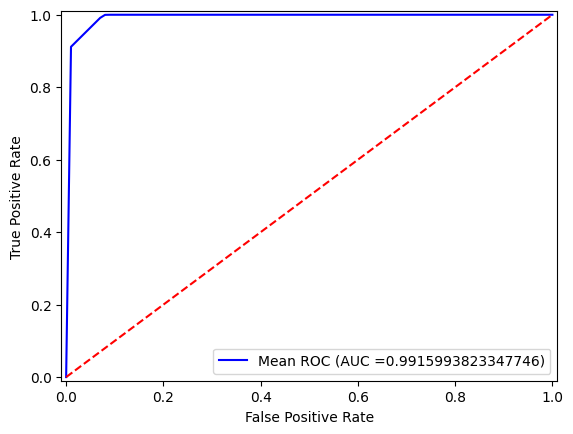

In [39]:
y_train = train_df['label'].to_numpy()

X_val = vectorizer.transform(val_df['body'])
y_val = val_df['label'].to_numpy()

reg = LogisticRegression(max_iter=200)

eval_model(reg, X_train, y_train, X_val, y_val)

### Evaluating Logistic Regression model on weight-balanced data:

Accuracy:  0.9721
Recall:  0.9618423013861976
Precision:  0.9964484249536751


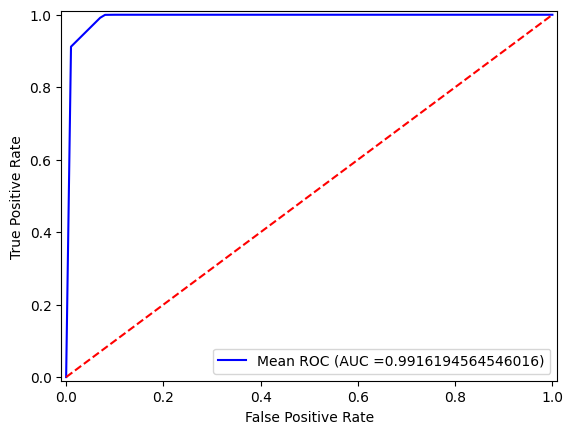

In [40]:
reg = LogisticRegression(max_iter=200, class_weight='balanced')
eval_model(reg, X_train, y_train, X_val, y_val)

### Evaluating Logistic Regression model on undersampled data:

Accuracy:  0.97
Recall:  0.9615844544095665
Precision:  0.993360098826436


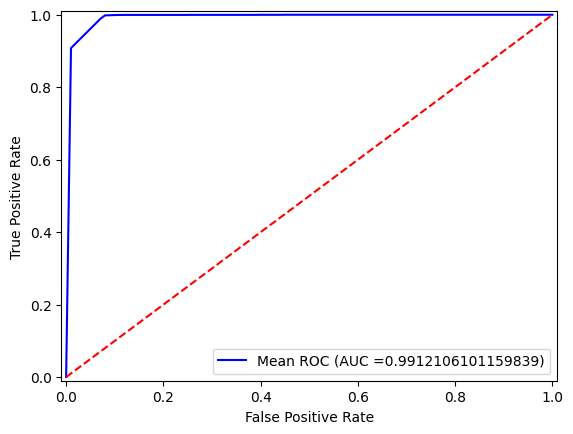

In [19]:
train_df, val_df, test_df = get_train_test_df(email_df, 0.7, 0.1)
train_df = under_sample_df(train_df,'label')

vectorizer = CountVectorizer(min_df=10)

X_train = vectorizer.fit_transform(train_df['body'])
y_train = train_df['label'].to_numpy()

X_val = vectorizer.transform(val_df['body'])
y_val = val_df['label'].to_numpy()

reg = LogisticRegression(max_iter=200)

eval_model(reg, X_train, y_train, X_val, y_val)

### Evaluating Logistic Regression using Binary CountVectorizer:

Accuracy:  0.9697
Recall:  0.9618434834655095
Precision:  0.9925880172946263


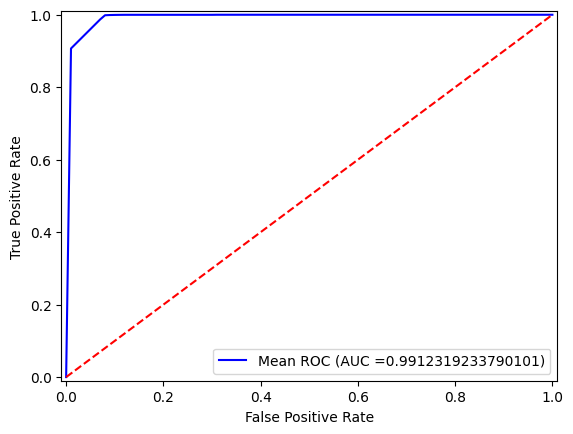

In [20]:
vectorizer = CountVectorizer(min_df=10, binary=True)
X_train = vectorizer.fit_transform(train_df['body'])

y_train = train_df['label'].to_numpy()

X_val = vectorizer.transform(val_df['body'])
y_val = val_df['label'].to_numpy()

reg = LogisticRegression(max_iter=200)

eval_model(reg, X_train, y_train, X_val, y_val)

### Evaluating XGBoost Classifier:

c:\Users\nelsonni\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Accuracy:  0.9311
Recall:  0.9080524608658863
Precision:  0.9942865966646078


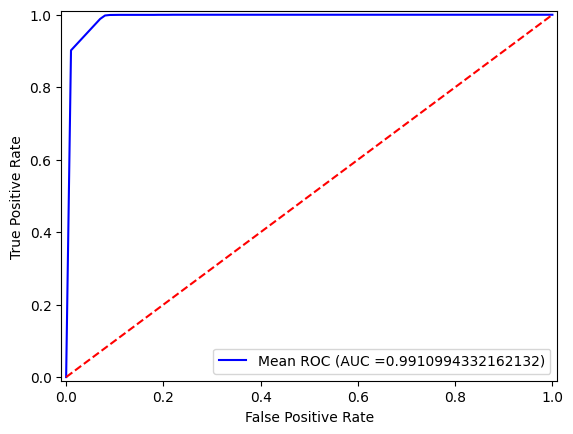

In [21]:
vectorizer = CountVectorizer(min_df=10)
X_train = vectorizer.fit_transform(train_df['body'])
y_train = train_df['label'].to_numpy()

X_val = vectorizer.transform(val_df['body'])
y_val = val_df['label'].to_numpy()

xgb_cl = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
eval_model(xgb_cl, X_train, y_train, X_val, y_val)

### Evaluating XGBoost Classfier using 200 estimators:

c:\Users\nelsonni\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Accuracy:  0.9311
Recall:  0.9080524608658863
Precision:  0.9942865966646078


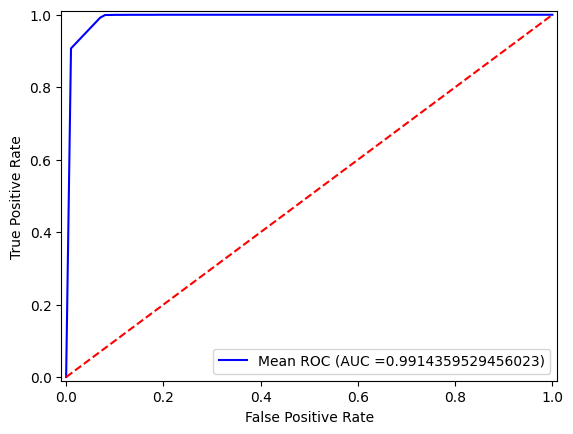

In [22]:
xgb_cl = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=200)
eval_model(xgb_cl, X_train, y_train, X_val, y_val)

### Evaluating MLP Classifier:

c:\Users\nelsonni\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Accuracy:  0.9311
Recall:  0.9080524608658863
Precision:  0.9942865966646078


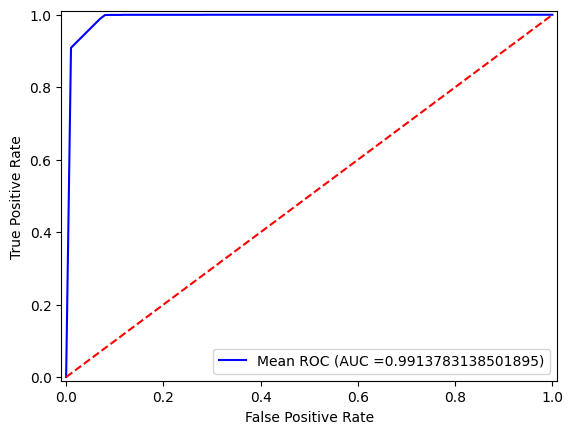

In [23]:
mlp = MLPClassifier(early_stopping=True, max_iter=50)
eval_model(mlp, X_train, y_train, X_val, y_val)

### Evaluating Gaussian Naive Bayes:

### Evaluating Linear SVC:

In [49]:
gnb = GaussianNB()
eval_model(gnb, X_train.toarray(), y_train, X_val.toarray(), y_val)

MemoryError: Unable to allocate 17.7 GiB for an array with shape (70000, 33951) and data type float64

In [ ]:
svc = SVC(kernel='linear',probability=True, max_iter=3)
eval_model(svc, X_train.toarray(), y_train, X_val, y_val)

### Best Performing Combination:
LogisticRegression model, using max_iter=200 + default parameters and CountVecotorizer using min_df=10 + default parameters.

### Evaluating on Test set:

Accuracy:  0.9745
Recall:  0.963385533184191
Precision:  0.9985314577214407


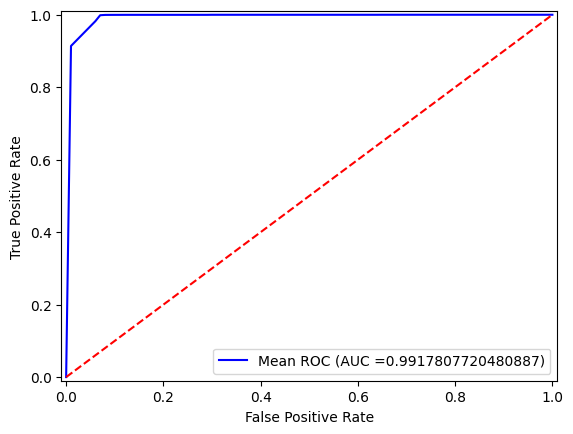

In [27]:
train_df, val_df, test_df = get_train_test_df(email_df, 0.7, 0.1)

vectorizer = CountVectorizer(min_df=10)

X_train = vectorizer.fit_transform(train_df['body'])
y_train = train_df['label'].to_numpy()

X_test = vectorizer.transform(test_df['body'])
y_test = test_df['label'].to_numpy()

reg = LogisticRegression(max_iter=200)

eval_model(reg, X_train, y_train, X_test, y_test)

In [52]:
reg.fit(X_train , y_train)

predictions = reg.predict(X_test)

accuracy = accuracy_score(predictions, y_test)
recall = recall_score(predictions, y_test, pos_label=1)
precision = precision_score(predictions, y_test, pos_label=1)

output_json = {}

output_json['reg_params'] = reg.get_params()
output_json['vect_params'] = vectorizer.get_params()
output_json['vect_params'].pop('dtype')
output_json['vect_params']['ngram_range'] = (1,1)
output_json['metrics'] = {'accuracy': accuracy, 'recall': recall, 'precision': precision}


c:\Users\nelsonni\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [53]:
with open('pipeline_config.json', 'w+') as f:
    json.dump(output_json, f)